# SVD-based (image) compression

As an exercise in applying the SVD, this notebook asks you to apply it to the literal problem of compression, in this case for images. That is, you'll use the SVD to make compress an image. This use of the SVD is _different_ from the one in Part 0, where you needed an SVD to solve the PCA problem. In this part, you'll use the SVD as a "standalone" tool.

> This problem was original a final exam question in an earlier edition of the on-campus class, so if nothing else consider it good practice.

## Setup

Let's load some modules and an image, which you will use the SVD to compress.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from PIL import Image

def im2gnp(image):
    """Converts a PIL image into an image stored as a 2-D Numpy array in grayscale."""
    return np.array(image.convert ('L'))

def gnp2im(image_np):
    """Converts an image stored as a 2-D grayscale Numpy array into a PIL image."""
    return Image.fromarray(image_np.astype(np.uint8), mode='L')

def imshow_gray(im, ax=None):
    if ax is None:
        f = plt.figure()
        ax = plt.axes()
    ax.imshow(im,
              interpolation='nearest',
              cmap=plt.get_cmap('gray'))

Let's download an image and represent it by a Numpy matrix, `img`.

In [2]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    print (local_file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))
    
URL_BASE = "https://cse6040.gatech.edu/datasets/tech-tower/"
DATA_PATH = "../resource/asnlib/publicdata/" if on_vocareum() else ""
datasets = {'tt1.jpg': '380479dfdab7cdc100f978b0e00ad814'}

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")

tt1.jpg
'tt1.jpg' is ready!

(All data appears to be ready.)


Next, let's convert this image to grayscale and print some stats, e.g., its dimensions and size (in pixels).

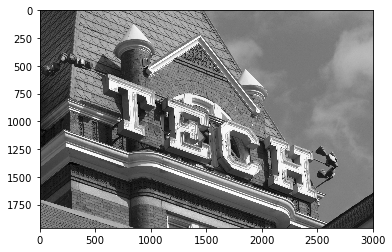

In [3]:
pic_raw = Image.open('{}tt1.jpg'.format(DATA_PATH), 'r')
pic = im2gnp(pic_raw)
imshow_gray(pic)

**Exercise 0** (1 point). Write a function that, given `I`, a 2-D Numpy array of (grayscale) image pixels, returns the total number of pixels.

In [4]:
def sizeof_image(I):
    assert type(I) is np.ndarray
    assert len(I.shape) == 2
    return I.shape[0] * I.shape[1]

In [5]:
# Test cell: `sizeof_image_test`

pic_pixels = sizeof_image (pic)

print ("The image uses about {:.1f} megapixels.".format (1e-6 * pic_pixels))

assert pic_pixels == 5895680
print ("\n(Passed!)")

The image uses about 5.9 megapixels.

(Passed!)


## Compression via the truncated SVD

Recall that the $k$-truncated SVD gives the best rank-$k$ approximation to a matrix $A$. That is, if the SVD of $A$ is $A = U \Sigma V^T$, then we can approximate $A$ by

$$
  A \approx U_k \Sigma_k V_k^T,
$$

where $(U_k, \Sigma_k, V_k^T)$ is the $k$-truncated SVD, taken by retaining the $k$ largest singular values (entries of diagonal matrix $\Sigma$), as well as the first $k$ columns of the left and right singular vectors ($U$ and $V$).

**Key idea.** For the rest of this notebook, if you understand the following idea, then the rest should make sense.

Suppose we represent the image as a matrix, $A$. Then we can also approximate $A$ with its $k$-truncated SVD, $(U_k, \Sigma_k, V_k^T)$. **If you can choose $k$ so that the size of the representation, $(U_k, \Sigma_k, V_k^T)$, is less than the size of original image, then we have compressed it.**

**Exercise 1** (2 point). Write a function, `compress_image(I, k)`, that compresses an input image `I` by interpreting `I` as a matrix, computing its `k`-truncated SVD, and then returning a compressed representation.

For this function, we want you to return a tuple, `(S, Uk, VkT)`, where `S` is an array of _all_ the singular values (not just the top $k$) and `Uk` and `VkT` are the $k$-_truncated_ singular vectors.

In [6]:
def compress_image(I, k):
    from scipy.linalg import svd
    Uk, Sigma, VkT = svd(I)
    return (Sigma, Uk[:,:k], VkT[:k,:])

# Runs your function:
k = 10
Sigma, Uk, VkT = compress_image(pic, k)

print(Sigma.shape)
print(Uk.shape)
print(VkT.shape)

(1960,)
(1960, 10)
(10, 3008)


In [7]:
# Test cell: `compress_image_test`

assert Sigma.shape == (min(pic.shape),)
assert Uk.shape == (pic.shape[0], k)
assert VkT.shape == (k, pic.shape[1])
assert (Sigma[k:]**2).sum () <= 7e9

print ("\n(Passed!)")


(Passed!)


**Exercise 2** (2 points). Write a function, `sizeof_compressed_image()`, that returns the number of "equivalent pixels" used by the compressed (truncated SVD) representation.

What are "equivalent pixels?" Recall these facts:

- In the original grayscale image, only **1 byte** is needed to store each pixel.
- In the (truncated) SVD representation, you need to store $U_k$, $V_k$, and $\Sigma_k$. Each entry of these matrices is a double-precision value, which requires **8 bytes**. Thus, one matrix entry is like 8 equivalent pixels of the original image.

In your implementation of this function, count just the $k$ largest singular values even though we asked that your `compress_image()` function return _all_ of the singular values. (We need all of them to analyze the error later on, but in an actual compression problem, we would presumably retain just the $k$ we need for the rank-$k$ representation.)

In [8]:
def sizeof_compressed_image(Sigma, Uk, VkT):
    return 8 * Uk.shape[1] * (Uk.shape[0] + 1 + VkT.shape[1])

In [9]:
# Test cell: `sizeof_compressed_image_test`

cmp_pixels = sizeof_compressed_image(Sigma, Uk, VkT)

print("Original image required ~ {:.1f} megapixels.".format (1e-6 * pic_pixels))
print("Compressed representation retaining k={} singular values is equivalent to ~ {:.1f} megapixels.".format (k, 1e-6 * cmp_pixels))
print("Thus, the compression ratio is {:.1f}x.".format (pic_pixels / cmp_pixels))

assert cmp_pixels == 397520
print ("\n(Passed!)")

Original image required ~ 5.9 megapixels.
Compressed representation retaining k=10 singular values is equivalent to ~ 0.4 megapixels.
Thus, the compression ratio is 14.8x.

(Passed!)


**Exercise 3** (2 points). Recall that the error of the compressed representation, as measured in the squared Frobenius norm, is given by the sum of the trailing singular values,

$$
  \|A - U_k \Sigma_k V_k^T\|_F^2 = \sigma_{k}^2 + \sigma_{k+1}^2 + \cdots + \sigma_{s-1}^2,
$$

where $s = \min(m, n)$ if $A$ is $m \times n$ and we assume that the singular values are sorted from largest ($\sigma_0$) to smallest ($\sigma_{s-1}$).

Write a function that returns the _relative_ error, measured using the Frobenius norm, i.e.,

$$
  \dfrac{\|A - U_k \Sigma_k V_k^T\|_F}
        {\|A\|_F}
        .
$$

> The first formula above is $\|\cdot\|_F^2$, whereas the relative error we want you to return is in terms of $\|\cdot\|_F$ (not squared).

In [10]:
def compression_error (Sigma, k):
    """
    Given the singular values of a matrix, return the
    relative reconstruction error.
    """
    S_sqrd = Sigma ** 2
    return (S_sqrd[k:].sum() / (S_sqrd[k:].sum() + S_sqrd[:k].sum())) ** 0.5

In [11]:
# Test cell: `compression_error_test`
print(Sigma)
print(k)
err = compression_error(Sigma, k)
print ("Relative reconstruction (compression) error is ~ {:.1f}%.".format (1e2*err))
assert 0.24 <= err <= 0.26
print ("\n(Passed!)")

[2.8924488e+05 3.8941234e+04 3.6186910e+04 ... 8.0024729e+00 7.9097366e+00
 7.8221531e+00]
10
Relative reconstruction (compression) error is ~ 25.1%.

(Passed!)


**Exercise 4** (2 points). Write a function that, given the compressed representation of an image, reconstructs it approximately by multiplying out the truncated SVD.

> Return this product "as-is," that is, you do not need to convert it into an integer pixel representation even though the original image is stored as integers.

In [12]:
def uncompress_image(Sigma, Uk, VkT):
    assert Uk.shape[1] == VkT.shape[0] # k
    return (Uk * Sigma[:Uk.shape[1]]).dot(VkT)

Measured relative error is ~ 25.1%.

(Passed!)


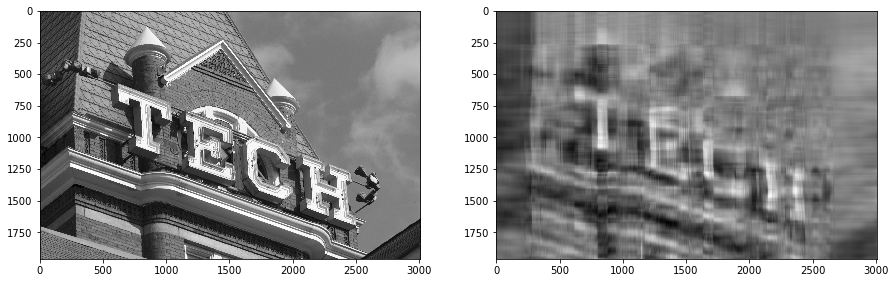

In [13]:
# Test cell: `uncompress_image_test`

pic_lossy = uncompress_image(Sigma, Uk, VkT)
#assert isinstance(pic_lossy, np.ndarray), "Your function should return a Numpy array."
#assert pic_lossy.shape == pic.shape, "Your function should return an image of the same size as the original."
#assert pic_lossy.dtype == pic.dtype, f"Your returned image has the wrong element type, {pic_lossy.dtype}, instead of {pic.dtype}."

f, ax = plt.subplots(1, 2, figsize=(15, 30))
imshow_gray(pic, ax[0])
imshow_gray(pic_lossy, ax[1])

abs_err = np.linalg.norm(pic - pic_lossy, ord='fro')
rel_err = abs_err / np.linalg.norm(pic, ord='fro')
print("Measured relative error is ~ {:.1f}%.".format(1e2 * rel_err))

pred_rel_err = compression_error(Sigma, k)
assert 0.95*pred_rel_err <= rel_err <= 1.05*pred_rel_err
print("\n(Passed!)")

**Exercise 5** (3 points). Complete the function, `find_rank(rel_err_target, Sigma)`, below. It should take as input the singular values (`Sigma`) and determine the truncation point, $k$, where the relative error just falls below a given target, `rel_err_target`. In other words, this function should determine at what value of $k$ a $k$-truncated SVD will achieve a desired accuracy.

> _Hint:_ You may find Numpy's [cumulative sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) handy.

In [14]:
def find_rank(rel_err_target, Sigma):
    relative_error = (np.cumsum((Sigma ** 2)[::-1])[::-1] / np.cumsum((Sigma ** 2)[::-1])[::-1][0]) ** 0.5
    return np.min(np.where(relative_error < rel_err_target))
    
rel_err_target = 0.15
k_target = find_rank(rel_err_target, Sigma)

print("Relative error target:", rel_err_target)
print("Suggested value of k:", k_target)

Relative error target: 0.15
Suggested value of k: 47


Compressing...
Estimated compression ratio: 3.2x

(Passed!)


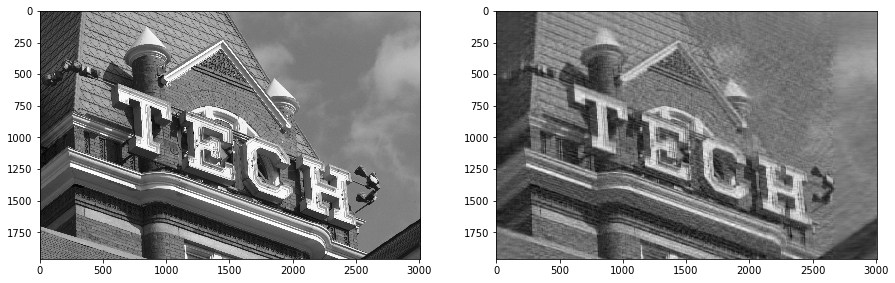

In [15]:
# Test cell: `find_rank_test`

print("Compressing...")
Sigma_target, Uk_target, VkT_target = compress_image(pic, k_target)
target_pixels = sizeof_compressed_image(Sigma_target,
                                        Uk_target,
                                        VkT_target)
target_ratio = pic_pixels / target_pixels
print("Estimated compression ratio: {:.1f}x".format(target_ratio))

pic_target = uncompress_image(Sigma_target, Uk_target, VkT_target)
f, ax = plt.subplots(1, 2, figsize=(15, 30))
imshow_gray(pic, ax[0])
imshow_gray(pic_target, ax[1])

assert compression_error(Sigma, k_target) <= rel_err_target
assert compression_error(Sigma, k_target-1) > rel_err_target

print("\n(Passed!)")

**Fin!** That's the end of this notebook. If you've understood it and passed the autograder, then you have completed this assignment.